In [83]:
# Importing some things to get rid of warnings
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


In [84]:
# The usual suspects

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import SP500models as models

In [85]:
from data_pipeline.processing import sharpe_normalize, risk
from data_pipeline.processing import l2_normalization
from data_pipeline.processing import correlation_histogram
from data_pipeline.processing import market_adjust
from data_pipeline.processing import industry_adjust

To do the clustering, I made a class that keeps all of the running scores and the relevant data. This makes it easier to tune parameters down the line.

In [86]:
class KMeans_Clustering_SP500():
    def __init__(self, n_min = 2, n_max = None,  test_size = 7, use_validation = True):

        self.test_size = 7        
        self.scores = {"DaviesBouldin": [], "CalinskiHarabasz": [], "Silhouette": [], "ElMehdi" : []}
        self.labels = []
        
        self.n_min = n_min
        self.n_max = n_max+1
        
        self.val = use_validation
        
        self.clusters = []

    def magic_score(self, SH,DB,CH):
        #return ((SH+1)/2) * np.arctan(DB)/(np.pi/2) * np.exp(-CH)
        return (SH+1)/2 * (1/(DB + 1) * (CH/(CH + 1)))
        #return ((SH + 1)/2 +  + )
    # the fit function behaves almost exactly like the usual scikit learn models.

    def fit(self, data):
        self.X = data
        
        # If no maximum clusters given, use the data
        if self.n_max == None:
            self.n_max = len(self.X.columns) - 1
        
        # doing the train-test split
        if self.val == True:
            self.X_train = self.X.iloc[:-self.test_size, :]
            self.X_test = self.X.iloc[-self.test_size:, :]
        
        if self.val == False:
            self.X_train = self.X
            self.X_test = self.X

        
        # perform the kmeans fitting for each n between n_min and n_max:
        for i in range(self.n_min, self.n_max):
            #print(f"Fitting Kmeans with {i} clusters")
            kmeans = KMeans(n_clusters = i, 
                            init='k-means++', 
                            max_iter=300, 
                            n_init=10,
                            random_state=0).fit(self.X_train.T.values)
            # stores the labels of the clustering
            self.labels.append(kmeans.labels_)
            
            cluster = dict(zip(self.X_train.columns, kmeans.labels_))
            self.clusters.append(cluster)
            
            # scores the clustering
            DB_test = davies_bouldin_score(self.X_test.T.values, kmeans.labels_)
            CH_test = calinski_harabasz_score(self.X_test.T.values, kmeans.labels_)
            Sil_test = silhouette_score(self.X_test.T.values, kmeans.labels_, metric='euclidean')
            ElMehdi_test = self.magic_score(Sil_test, CH_test, DB_test)

            self.scores["DaviesBouldin"].append(DB_test)
            self.scores["CalinskiHarabasz"].append(CH_test)
            self.scores["Silhouette"].append(Sil_test)
            self.scores["ElMehdi"].append(ElMehdi_test)
        print("Finished fitting. Generating plots...")
    

    # this bit of code produces pretty pictures.
    def summarize(self, comparison = None):
        comparison_labels = list(comparison.values())

        DB_compare = davies_bouldin_score(self.X_test.values.T, 
                                          comparison_labels)
        CH_compare = calinski_harabasz_score(self.X_test.values.T, 
                                             comparison_labels)
        Sil_compare = silhouette_score(self.X_test.values.T, 
                                       comparison_labels, 
                                       metric='euclidean')
        ElMehdi_compare = self.magic_score(Sil_compare, DB_compare, CH_compare)


        f, axarr = plt.subplots(4, sharex=False, figsize = (6,6))
        f.set_figheight(12)
        f.set_figwidth(12)

        axarr[0].set_title("Comparing scores between kmeans and Industry clusters (in red)")
        axarr[3].set_xlabel("number of clusters in kmeans")

        p1 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["DaviesBouldin"], 
                          ax = axarr[0])
        p1.axhline(y = DB_compare, color = 'red')
        p1.set_ylabel("Davies Bouldin Score (low is good)")

        p2 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["CalinskiHarabasz"],
                          ax = axarr[1], 
                          legend = False)
        p2.axhline(y = CH_compare, color = 'red')
        print(f"Baseline CH score: {CH_compare}")
        p2.set_ylabel("Calinski Harabasz Score (high is good)")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["Silhouette"], 
                          ax = axarr[2], 
                          legend = False)
        p3.axhline(y = Sil_compare, color = 'red')
        p3.set_ylabel("Silhouette Score (high is good)")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                        y = self.scores["ElMehdi"], 
                        ax = axarr[3], 
                        legend = False)
        p3.axhline(y = ElMehdi_compare, color = 'red')
        p3.set_ylabel("El Mehdi's magical score")

        axarr[0].grid('on', which='major', axis='x' )
        axarr[1].grid('on', which='major', axis='x' )
        axarr[2].grid('on', which='major', axis='x' )
        axarr[3].grid('on', which='major', axis='x' )
        if (self.n_max - self.n_min) > 20:
            axarr[0].minorticks_on()
            axarr[1].minorticks_on()
            axarr[2].minorticks_on()
            axarr[3].minorticks_on()
            
            axarr[0].grid('on', which='minor', axis='x' )
            axarr[1].grid('on', which='minor', axis='x' )
            axarr[2].grid('on', which='minor', axis='x' )
            axarr[3].grid('on', which='minor', axis='x' )



        plt.show()

# Doing the fitting and modeling

For this kmeans, we tune two parameters that do not exist in the usual kmeans algorithm:
- smoothing: the idea is to scale down data that is far from the prediction horizon. This smoothing factor is a number between 0 and 1, and if $r_{-i}$ is the return of investment $i$ days ago, then the smoothing factor transforms the data $r_{-i} \to (smoothing)^i * r_{-i}$. In other words, it exponentially decays the effect of older days
- test_size: since we are doing a time series, all clustering metrics are measured on the validation data instead of the training data. test_size tunes this parameter. This can be toggled on or off with the use_validation argument, which is by default set to True.

In [87]:
# baseline clusters = industry
import pickle
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

# Clustering returns

Finished fitting. Generating plots...
Baseline CH score: 7.432348735804405


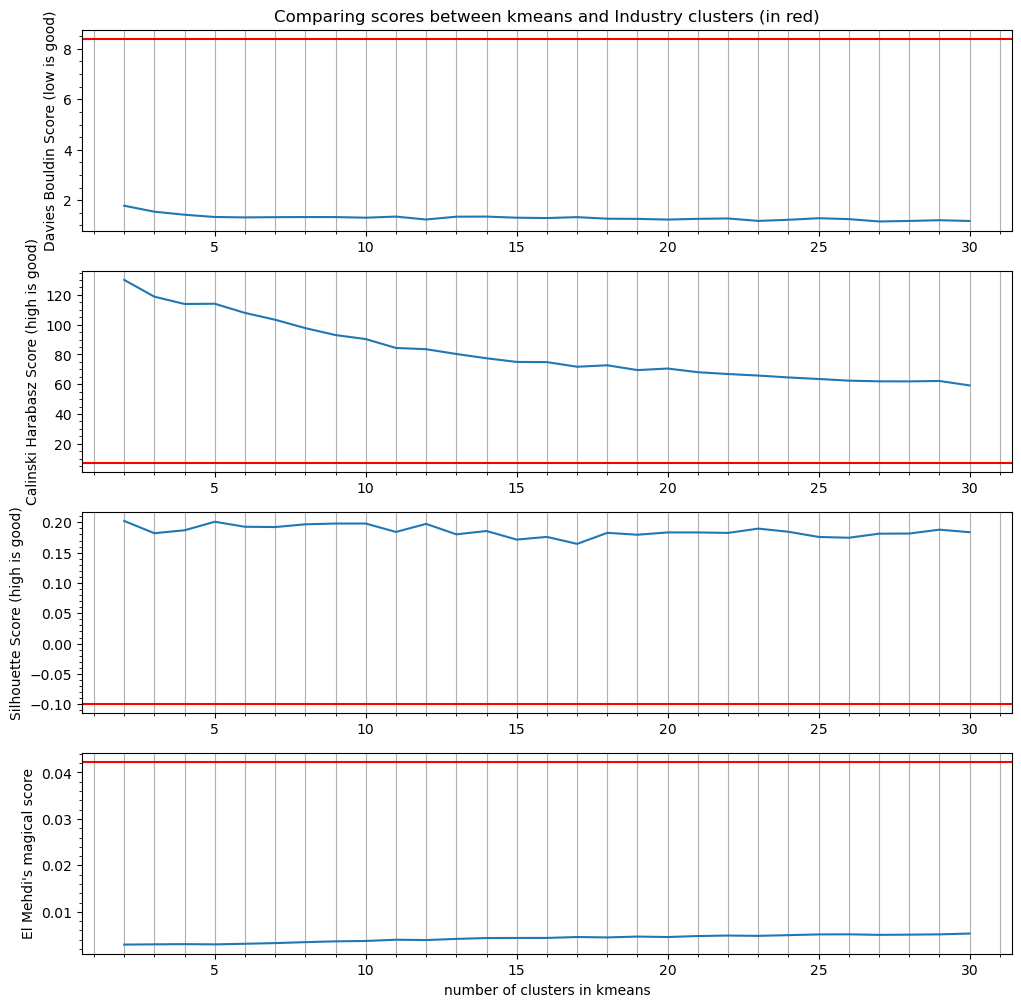

In [160]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl)

closing_prices = closing_prices
ROR = closing_prices.pct_change().dropna()
#ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))
ROR = l2_normalization(ROR)[19:]

test_size = 1
kmeansSP500 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 30,
                                      test_size = test_size, 
                                      use_validation = False)
kmeansSP500.fit(ROR)
kmeansSP500.summarize(industry_clusters)

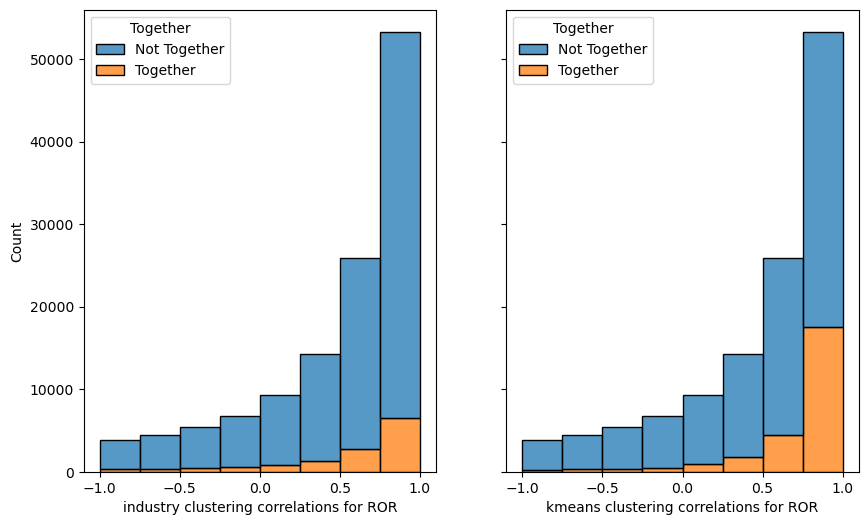

In [161]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])
best_cluster_ind = 3
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500.clusters[best_cluster_ind], ax = axarr[1])


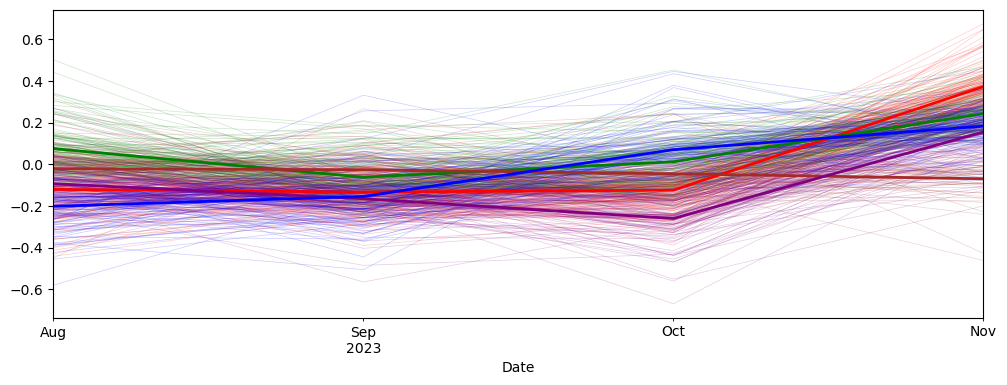

In [162]:
clusters = kmeansSP500.clusters[best_cluster_ind]
clust_to_tick = {label : [tick for tick in clusters.keys() if clusters[tick] == label] for label in clusters.values()}

fig, ax = plt.subplots(figsize = (12,4))
colors = ["red", "blue", "green", "purple", "brown"]

for i in clust_to_tick.keys():
    ROR[clust_to_tick[i]].plot(legend = False, color = colors[i], ax=ax, alpha = 0.2, linewidth = 0.5)
for i in clust_to_tick.keys():
    ROR[clust_to_tick[i]].mean(axis = 1).plot(legend = False, color = colors[i], ax=ax, alpha = 1, linewidth = 2)


In [150]:
ROR

Ticker,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-01 00:00:00-04:00,-0.075362,0.108978,-0.224123,0.073361,0.240157,-0.037789,0.109510,0.206621,-0.254464,0.291275,...,0.044067,-0.032950,-0.051351,-0.149577,-0.217466,-0.041132,-0.247946,-0.518217,-0.070005,0.180397
2023-09-01 00:00:00-04:00,-0.198154,-0.119445,-0.043611,0.198665,0.022976,0.045404,-0.098687,0.014406,-0.269718,0.281339,...,0.129132,0.112914,-0.071642,0.390793,-0.223511,0.120086,-0.222473,-0.034023,0.043064,-0.141322
2023-10-01 00:00:00-04:00,0.030779,0.375760,0.257406,0.053348,0.121604,-0.062505,0.286741,-0.199599,-0.086583,0.187551,...,0.521555,0.341503,0.047332,0.240868,0.241653,0.146162,-0.162372,0.013525,-0.172823,-0.107273
2023-11-01 00:00:00-04:00,0.040567,-0.044134,0.123722,-0.207382,-0.073411,-0.034926,0.030451,-0.162927,0.287599,-0.239228,...,-0.245208,-0.061076,-0.373478,-0.249346,0.118984,-0.258093,-0.017389,0.131967,0.095895,0.162590


<AxesSubplot:xlabel='2023-08-01 00:00:00-04:00', ylabel='2023-09-01 00:00:00-04:00'>

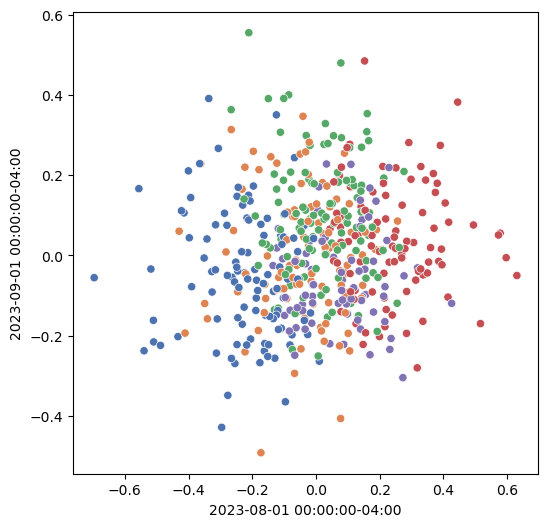

In [155]:
clusters = kmeansSP500.clusters[best_cluster_ind]
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = final_prices, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

In [156]:
import plotly.graph_objects as go

clusters = kmeansSP500.clusters[best_cluster_ind]
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns

fig = go.Figure(data = [go.Scatter3d(
    x = final_prices[cols[0]],
    y = final_prices[cols[1]],
    z = final_prices[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 4,
        color = final_prices['cluster'],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()


In [157]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

clusters = industry_clusters
name_to_num = {name : i for (i, name) in enumerate(set(industry_clusters.values()))}
clusters = {tick : name_to_num[industry_clusters[tick]] for tick in industry_clusters.keys()}
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns


fig = go.Figure(data = [go.Scatter3d(
    x = final_prices[cols[0]],
    y = final_prices[cols[1]],
    z = final_prices[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = final_prices[cols[3]],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()

As we can see, Kmeans on its own cannot beat the baseline model of industry clustering for risk-adjusted returns, which are the most useful for financial modeling.

There are two possible alternate approaches. 
- The first is to cluster *within* each industry cluster, and to refine the industry clustering. 
- The second is to try to remove the influence of "industry" on the sharpe rates of return, and then to try clustering again.